# MLP implementation of Make More

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
words = open('../data/names.txt', 'r').read().splitlines()

In [33]:
# build vocab of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [77]:
# building the dataset
block_size = 3 # context: How many characters do we take to predit the next character
X,Y = [],[]

for w in words:
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [82]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [37]:
C = torch.randn((27,2))


In [38]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([1.4295, 1.6472])

In [39]:
## Can use X as indices for C
embeddings = C[X]
print(f'Embeddings shape: {embeddings.shape}')

Embeddings shape: torch.Size([32, 3, 2])


In [40]:
W1 = torch.randn(6,100)
b1 = torch.randn(100)

In [41]:
## Now we want to multiply embedding with W1 and add b1
embeddings @ W1 + b1 
# this wont' work because shape of embeddings is different from W1. (emb: 32*3*2, W1: 6*100): We will need to reshape embeddings to 32*6


RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [42]:
## one way to do this is concatenate embeddings on dim 1
torch.cat([embeddings[:,0,:], embeddings[:,1,:], embeddings[:,2,:]], dim=1)
## Not generalisable to different batch sizes

tensor([[ 0.0177, -0.4458,  0.0177, -0.4458,  0.0177, -0.4458],
        [ 0.0177, -0.4458,  0.0177, -0.4458,  1.4295,  1.6472],
        [ 0.0177, -0.4458,  1.4295,  1.6472, -1.5955, -0.8440],
        [ 1.4295,  1.6472, -1.5955, -0.8440, -1.5955, -0.8440],
        [-1.5955, -0.8440, -1.5955, -0.8440,  0.9739,  0.4411],
        [ 0.0177, -0.4458,  0.0177, -0.4458,  0.0177, -0.4458],
        [ 0.0177, -0.4458,  0.0177, -0.4458, -0.3795,  1.4966],
        [ 0.0177, -0.4458, -0.3795,  1.4966,  1.3344,  0.0253],
        [-0.3795,  1.4966,  1.3344,  0.0253, -0.0627, -0.4234],
        [ 1.3344,  0.0253, -0.0627, -0.4234,  0.2306, -0.1500],
        [-0.0627, -0.4234,  0.2306, -0.1500, -0.0627, -0.4234],
        [ 0.2306, -0.1500, -0.0627, -0.4234,  0.9739,  0.4411],
        [ 0.0177, -0.4458,  0.0177, -0.4458,  0.0177, -0.4458],
        [ 0.0177, -0.4458,  0.0177, -0.4458,  0.9739,  0.4411],
        [ 0.0177, -0.4458,  0.9739,  0.4411,  0.2306, -0.1500],
        [ 0.9739,  0.4411,  0.2306, -0.1

# How do we combine last two dims in x?
- We use torch.unbind: https://docs.pytorch.org/docs/stable/generated/torch.unbind.html
- e.g : torch.cat(torch.unbind(embeddings, dim=1), dim=1).shape
- Inefficient, creates new memory which may not be ideal

In [43]:
torch.cat(torch.unbind(embeddings, dim=1), dim=1).shape


torch.Size([32, 6])

## There is a better way to do this:
- using .view() in pytorch
    - Extremely efficienct: underlying storage represents it as a 1D vector always
    - No changes to storage/ memory so efficienct. No cost to us
    - Manipulates shape, strides and storage offset
    - More details here: https://blog.ezyang.com/2019/05/pytorch-internals/

In [44]:
embeddings.view(32,6) == torch.cat(torch.unbind(embeddings, dim=1), dim=1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [45]:
# this multiplication should work now
h = embeddings.view(-1,6) @ W1 + b1 # hidden state
h

tensor([[-1.3499,  2.1780,  0.2391,  ...,  0.4929, -0.8436,  0.6192],
        [-1.6955,  1.3003,  0.3824,  ..., -0.4157, -1.0276, -1.8854],
        [-1.2244, -7.2536, -1.0428,  ...,  4.5604,  0.9774,  1.7928],
        ...,
        [-1.8376,  2.9268,  3.3890,  ...,  3.3738,  1.0292, -1.2682],
        [-1.4196, -1.1756, -0.9800,  ...,  0.0353, -0.7518,  1.0998],
        [-1.3923,  1.9277,  1.0334,  ..., -0.3886,  1.8937, -0.7900]])

In [46]:
h.shape

torch.Size([32, 100])

In [47]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [48]:
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)
probs

tensor([[5.3946e-15, 4.8748e-13, 5.6456e-19, 1.3147e-18, 6.2133e-28, 9.9550e-01,
         6.7829e-09, 5.6514e-21, 9.9679e-08, 1.7460e-13, 9.3759e-14, 9.0445e-08,
         4.4071e-03, 1.1132e-13, 9.6373e-11, 9.0226e-05, 1.7868e-16, 4.2478e-13,
         6.2260e-08, 1.1751e-14, 5.5616e-13, 1.5209e-07, 7.3494e-12, 1.8000e-10,
         5.0991e-10, 5.4082e-06, 4.5334e-16],
        [2.0675e-32, 7.6135e-36, 7.6500e-27, 1.1859e-34, 0.0000e+00, 3.5049e-16,
         0.0000e+00, 2.1156e-39, 3.0156e-29, 3.2214e-27, 0.0000e+00, 1.0000e+00,
         9.2602e-23, 7.6701e-35, 0.0000e+00, 3.2234e-40, 1.4664e-30, 6.7262e-44,
         2.5879e-30, 1.2199e-35, 1.9757e-31, 2.8026e-45, 2.6472e-30, 2.1072e-19,
         3.1238e-27, 6.8122e-38, 1.5036e-36],
        [3.1473e-30, 3.1957e-35, 2.3557e-38, 6.6369e-40, 0.0000e+00, 5.1034e-27,
         2.4500e-21, 6.7247e-22, 8.9221e-25, 2.7524e-12, 3.6913e-27, 0.0000e+00,
         9.3434e-16, 1.2900e-18, 1.2310e-13, 1.4515e-19, 2.6338e-40, 9.4874e-19,
         0.0000e+

In [49]:
## Now we can get NLL loss.
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(inf)

# Make a trainnable NN now with loss backprop

In [114]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator =g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27,generator=g)
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params) # total 3481 params so far

3481

## Loss function: Why use F.cross_entropy() over your own implementation (logits and log probs)?
- F.cross_entropy() wont create intermediate tensors that you create when implementing your own logic
- Pytorch clusters up these operations and creates fused kernel to perform the operations efficiently
- Simpler backward pass. Easier to compute and implement
- F.cross_entropy() is numercially better behaved.
    - Because for logits, pytorch interanally calculates the max value that can occur in logits and subtracts it from logits. This offsets them by that amount. This is okay because -ve numbers aren't that big of an issue compared to positive numbers


In [109]:
print(W1.dtype, b1.dtype, W2.dtype, b2.dtype,C.dtype, torch.tanh(C[X].view(-1, 6) @ W1 + b1).dtype)

torch.float32 torch.float32 torch.float32 torch.float32 torch.float32 torch.float32


In [115]:
for p in params:
    p.requires_grad = True

In [116]:
lre = torch.linspace(-3,0,1000) # 1000 values between -3 and 0. This is exponents for learning rate
lrs = 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [102]:
# emb = C[X]
# h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# logits = h @ W2 + b2
# counts = logits.exp()
# probs = counts/counts.sum(1, keepdim=True)
# loss = -probs[torch.arange(32), Y].log().mean()
# print(f'loss:{loss}')

## can use torch.functional.cross_entropy to calculate this NLL loss
## comparing F.cross_entopy() with our own implementation for numerical stability
# logits = torch.tensor([-2,-3,0,100]) # problamatic example where logits are too large so exp goes to inf
# counts = logits.exp()
# probs = counts/counts.sum()
# print(f'probs:{probs}')

# ## how F.cross_entrop() handles this:
# logits = torch.tensor([-2,-3,0,100])-100 # problamatic example where logits are too large so exp goes to inf
# counts = logits.exp()
# probs = counts/counts.sum()
# print(f'probs:{probs}')


## replace loss with F.cross_entropy()
lri = []
lossi = []
for i in range(1000):
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in params:
        p.grad = None
        
    loss.backward()
    lr = lrs[i]
    
    for p in params:
        p.data+= -lr*p.grad
    lri.append(lr)
    lossi.append(loss.item())
print(f'loss final: {loss.item()}') 

KeyboardInterrupt: 

# Optimising this with minibatches
- Randomly select a subset of data to optimise 
- forward() and backward() only on these ranomly selected samples and not the wholle dataset
- speeds up the training significantly

In [112]:
lri = []
lossi = []
for i in range(1000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in params:
        p.grad = None
        
    loss.backward()
    lr = lrs[i]
    
    for p in params:
        p.data+= -lr*p.grad
    lri.append(lre[i])
    lossi.append(loss.item())
print(f'loss final: {loss.item()}')

loss final: 6.988081455230713


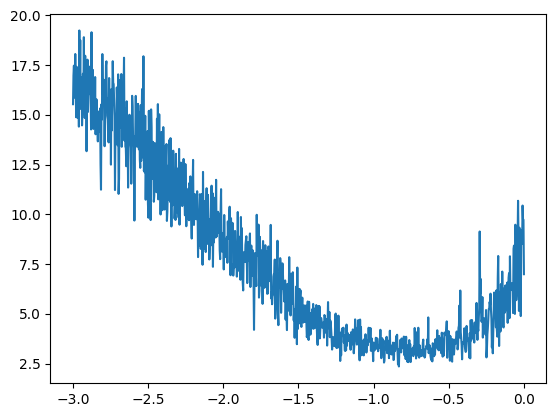

In [113]:
plt.plot(lri, lossi)

- -1.0 works pretty well here. So lr = 10**-1.0 = 0.1 is fairly good lr

In [137]:
for i in range(10000):
    ix = torch.randint(0, X.shape[0], (32,))
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in params:
        p.grad = None
        
    loss.backward()
    #lr = 0.1
    # lr = 0.01 # Learning rate decay (in later stages of training)
    for p in params:
        p.data+= -lr*p.grad
print(f'loss final: {loss.item()}')

loss final: 2.3681721687316895


In [138]:
# loss on entire dataset
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.4845, grad_fn=<NllLossBackward0>)

# Improve generalisability of model
- Train, test and validation splits
- Can be for e.g 80%, 10%, 10%
- Very rarely use test set

In [144]:
# building the dataset
def build_dataset(words):
    block_size = 3
    X,Y = [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

## Defining network

In [153]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator =g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27,generator=g)
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params) # total 3481 params so far

3481

In [154]:
for p in params:
    p.requires_grad = True

In [ ]:
for i in range(10000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in params:
        p.grad = None
        
    loss.backward()
    lr = 0.1
    # lr = 0.01 # Learning rate decay (in later stages of training)
    for p in params:
        p.data+= -lr*p.grad
print(f'loss final: {loss.item()}')

loss final: 2.5159733295440674


In [152]:
## check loss on training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3029, grad_fn=<NllLossBackward0>)

In [151]:
## check loss on validation set
emb = C[Xval]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.5447, grad_fn=<NllLossBackward0>)

Our training and dev losses are roughly equal so we might be underfitting the data. It would help if we scale our model up (make it more complex)

In [172]:
## Making the neural net more complex
## Adding more hidden layers
steps = []
losses = []
for i in range(30000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in params:
        p.grad = None
        
    loss.backward()
    lr = 0.01
    # lr = 0.01 # Learning rate decay (in later stages of training)
    for p in params:
        p.data+= -lr*p.grad
    steps.append(i)
    losses.append(loss.item())
print(f'loss final: {loss.item()}')

loss final: 2.299339532852173


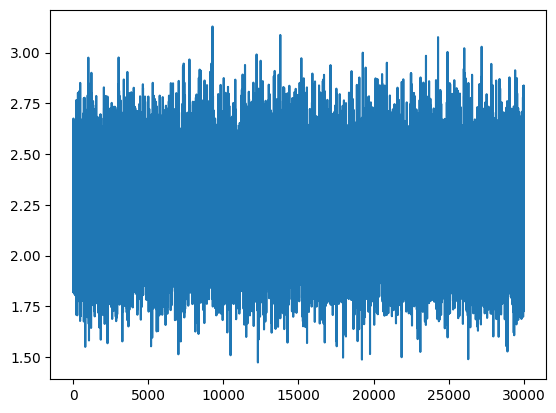

In [173]:
## plotting steps vs losses
plt.plot(steps, losses)

In [174]:
## check loss on training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2112, grad_fn=<NllLossBackward0>)

In [175]:
## check loss on validation set
emb = C[Xval]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.4603, grad_fn=<NllLossBackward0>)

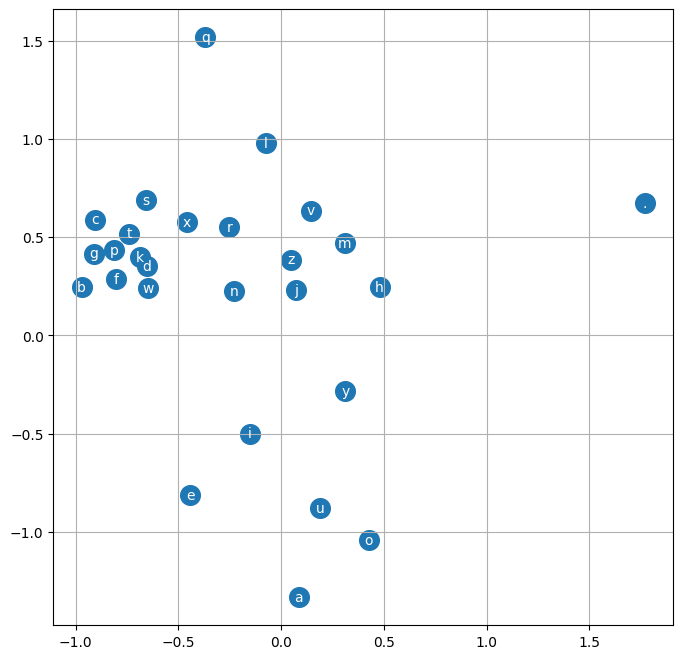

In [177]:
## Visualizing embeddings trained by NN
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha='center', va='center', color='white')
plt.grid('minor')

# Experiment: Making embedding vectors bigger
- Making the NN more complex didn't improve our training loss much. Let's experiment with increasing the embedding size
- We maybe squashing in too many characters in 2 dimensions, which may be too small

In [199]:
g = torch.Generator().manual_seed(2147483647) # random seed
C = torch.randn((27,10), generator=g) # changing them to 10 dim embeddings
W1 = torch.randn((3*10,200), generator =g)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27,generator=g)
params = [C, W1, b1, W2, b2]
sum(p.nelement() for p in params)  # 11K params

11897

In [200]:
for p in params:
    p.requires_grad = True

In [201]:
steps = []
losses = []

In [202]:
# training NN

for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in params:
        p.grad = None
        
    loss.backward()
    lr = 0.01
    # lr = 0.01 # Learning rate decay (in later stages of training)
    ## LR decay
    lr  = 0.1 if i > 100000 else 0.01
    for p in params:
        p.data+= -lr*p.grad
    steps.append(i)
    losses.append(loss.log10().item())
print(f'loss final: {loss.item()}')

loss final: 2.209224224090576


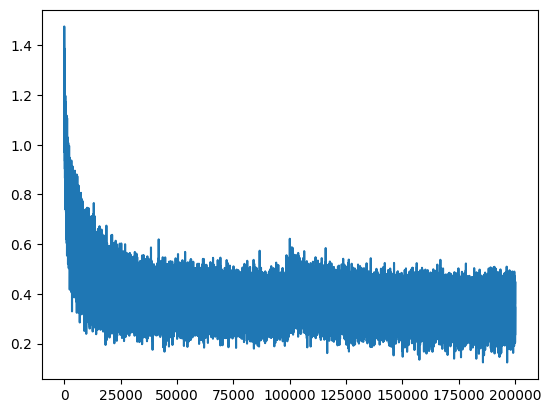

In [203]:
## plotting steps vs losses
plt.plot(steps, losses)

In [204]:
## check loss on training set
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1814, grad_fn=<NllLossBackward0>)

In [205]:
## check loss on validation set
emb = C[Xval]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.5062, grad_fn=<NllLossBackward0>)

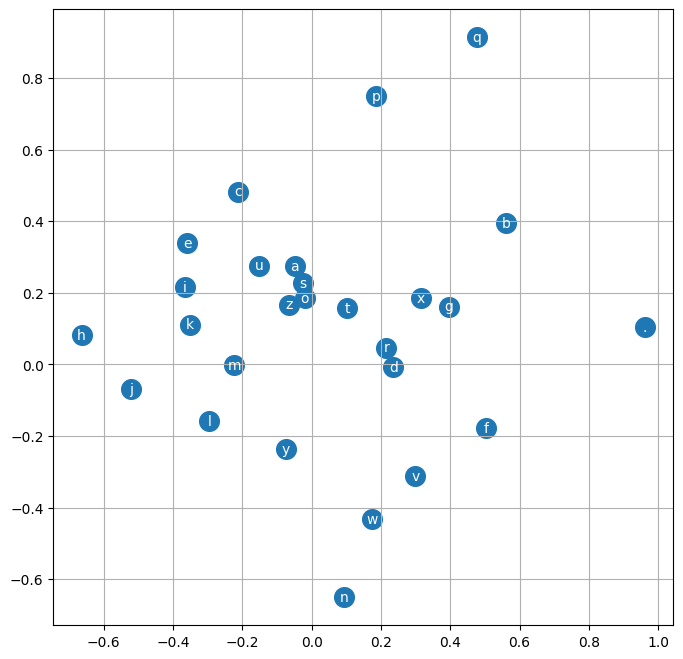

In [206]:
## Visualizing embeddings trained by NN
plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
## Sampling from the model
g = torch.Generator().manual_seed(2147483647+10)
for _ in range(50): # want to sample 50 words
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1) ## automatically makes sure there are no overflows
        ix = torch.multinomial(probs,num_samples = 1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0: # break till we generated a '.'
            break
    print(''.join(itos[i] for i in out))
        
        
        
    